In [1]:
%run initialising.ipynb
from matplotlib.ticker import MultipleLocator
import researchpy as rp
import itertools

In [2]:
def get_antimere_df(df, full_antimere, threshold, material, constant_n_obs):
    '''
    Args:
        df:
        measure_type:
        threshold:
        constant_n_obs:
    Returns:
        DataFrame with 4x columns – 'antimere', '%acc', 'material', 'measure type'
    '''
    
    measure_type = re.search('\.\w+', full_antimere).group()
    antimere = re.search('\d\d-\d\d', full_antimere).group()
    
    if not constant_n_obs:
        amDf = pd.DataFrame(getColumn(df, full_antimere, threshold, material)).dropna()
    else:
        if '7' in antimere:
            l = ['%s%s %%acc' % (antimere, x) for x in ['.ctd', '.ct', '.gm']]
        else:
            l = ['%s%s %%acc' % (antimere, x) for x in MEASURE_TYPES] # e.g. ['13-23.cc %acc', '13-23.ctd %acc', '13-23.ct %acc', '13-23.gm %acc']

        amDf = getThresholdDf(df, False, threshold, material)[l].dropna() #df with 4 columns of %acc for xx-xx.ctd/.cc/.gm/.ct all above threshold; dropna() means NaN values in any measure type will cause all measure types to be excluded              
        amDf = pd.DataFrame(amDf[full_antimere]) # df with 1 column 'xx-xx.xx %acc'
    amDf = amDf.rename(columns = lambda x: str(x)[-4:]) # df with 1 column '%acc'
    amDf['antimere'] = antimere
    amDf['material'] = material
    amDf['measure type'] = measure_type
    
    return amDf

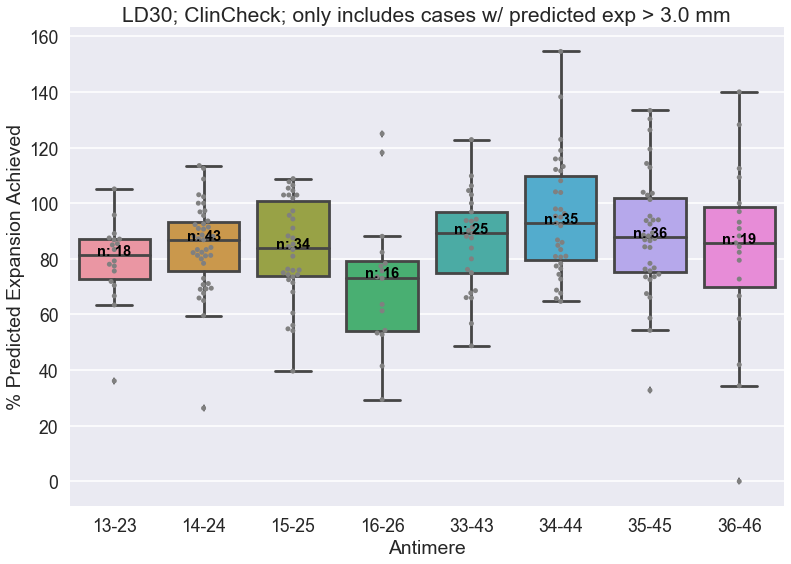

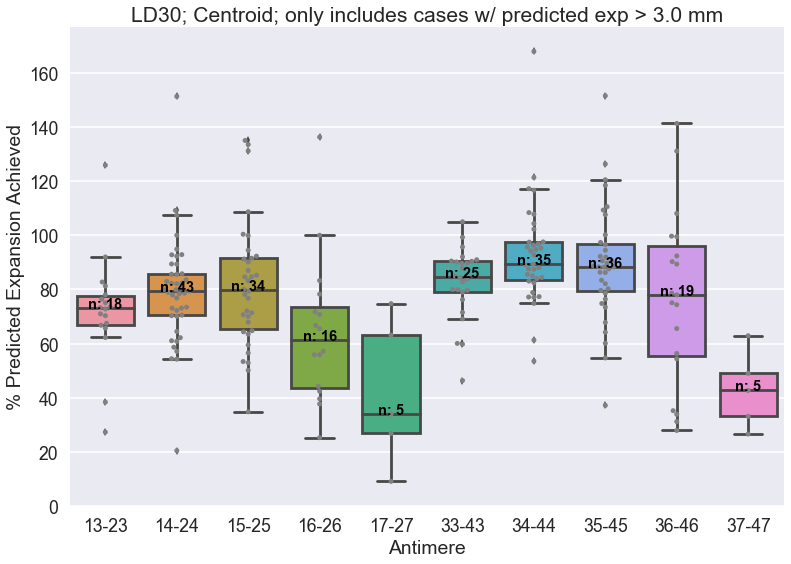

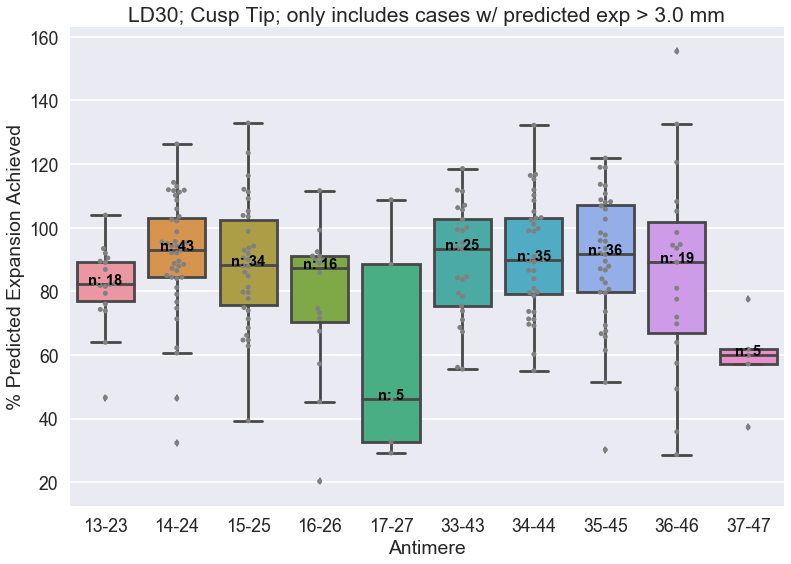

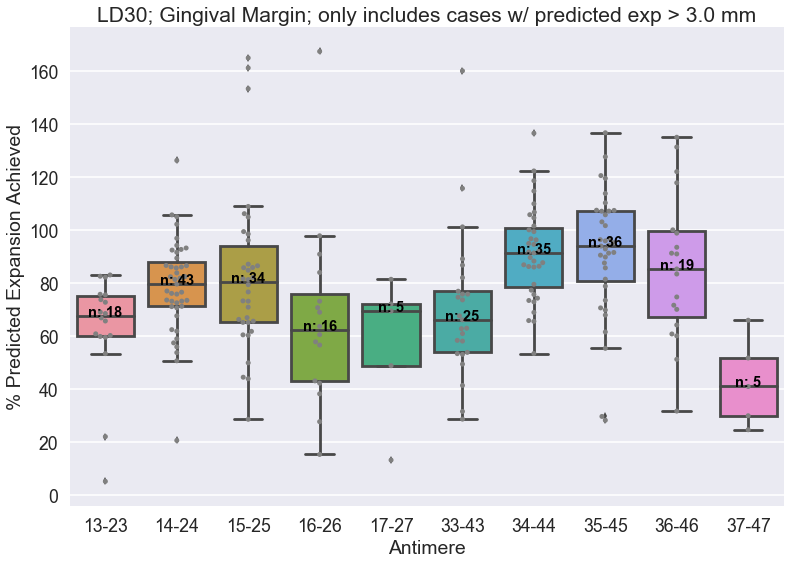

In [3]:
def boxPlot(df, measure_type, threshold, material, constant_n_obs=True):
    '''Boxplot: %Accuracy vs Antimere for a given measure_type & material.
    Only includes data where predicted exp > threshold.
    Also outputs .PDF of data.
    
    Args:
        df:
        measure_type:
        threshold:
        material:
        constant_n_obs:
            True –
                n is equal for each antimere across different measure types
                (e.g. if pt 111 has NaN value for 16-26.ctd, then will
                exclude 16-26.gm/.ct/.cc measurements)
            False – 
                includes all cases screened by other parameters (threshold)
                mainly, if NaN value exists for xx-xx.ctd, this does not impact
                whether other measure types of xx-xx are included.
    '''
    
    pp = PdfPages(os.path.join(OUTPUT_DIR, 'boxplots/boxplots-%s%s.pdf' % (material, measure_type)))
    
    sns.set('poster', font_scale=1.1)
#     sns.set_style('whitegrid', {'grid.linestyle':'--'})
#     sns.set_style('ticks', {'xtick.color':'0',
#                            'ytick.color':'0'})
    f = plt.figure()
    
    newDf = pd.DataFrame(columns = ['%acc', 'antimere', 'material'])
    
    for i, j in zip([1, 3], [2, 4]):
        for toothNum in range(3, 8):
            
            if measure_type == '.cc' and toothNum == 7:
                continue
            
            antimere = '%s%s-%s%s' % (i, toothNum, j, toothNum)
            full_antimere = '%s%s-%s%s%s %%acc' % (i, toothNum, j, toothNum, measure_type)
            
            amDf = get_antimere_df(df, full_antimere, threshold, material, constant_n_obs)
            newDf = pd.concat([newDf, amDf], ignore_index=True)

    ax = sns.boxplot(x='antimere', y='%acc', data=newDf)
    ax = sns.swarmplot(x='antimere', y='%acc', data=newDf, color="grey")
    
    ### Adding n to boxplot.
    # Calculate number of obs & median to position labels
    medians = newDf.groupby(['antimere'])['%acc'].median().values
    nobs = newDf.groupby(['antimere'])['%acc'].count().values
    nobs = [str(x) for x in nobs.tolist()]
    nobs = ["n: " + i for i in nobs]
    # Add it to the plot
    pos = range(len(nobs))
    for tick,label in zip(pos,ax.get_xticklabels()):
        ax.text(pos[tick], medians[tick] + 0.03, nobs[tick],
        horizontalalignment='center', size='x-small', color='k', weight='semibold')
    
    ## formatting
    ax.yaxis.set_major_locator(MultipleLocator(20))
    ax.yaxis.set_minor_locator(MultipleLocator(10))
    
    # Set titles
    ax.axes.set_title("%s; %s; only includes cases w/ predicted exp > %s mm" % (material, measure_type_dict[measure_type], threshold))
    ax.set_xlabel("Antimere")
    ax.set_ylabel("% Predicted Expansion Achieved")
    
    sns.plt.show()
    pp.savefig(f, bbox_inches="tight")
    pp.close()
    return

for measure_type in MEASURE_TYPES:
    boxPlot(df, measure_type, THRESHOLD, 'LD30')

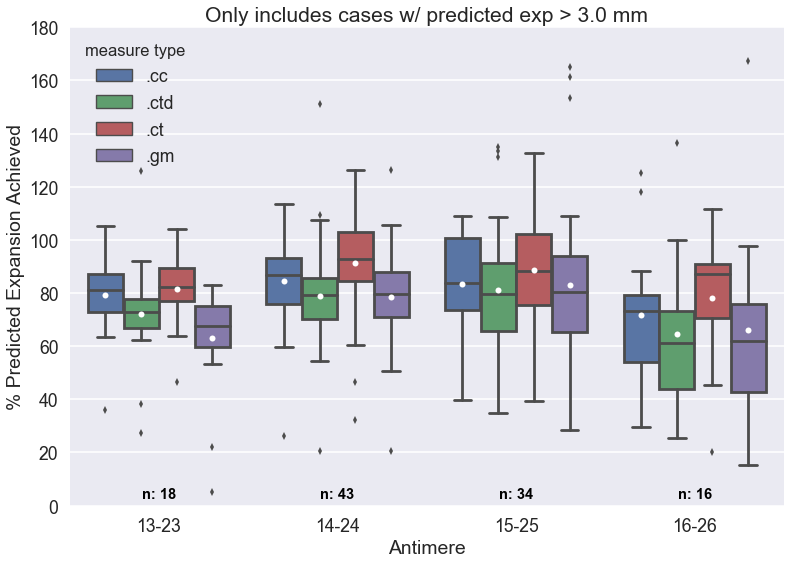

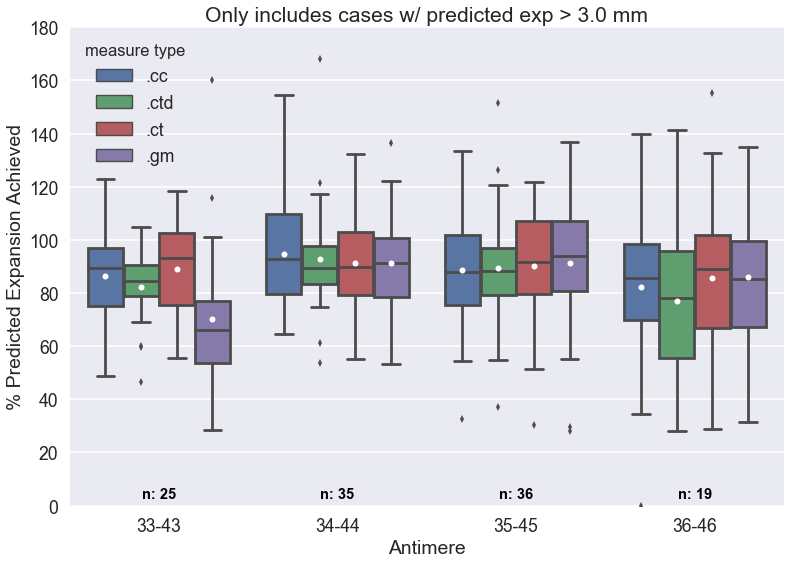

*Antimere: 13-23; ANOVA p: 0.00894101480294
*Antimere: 14-24; ANOVA p: 0.00351556743178
Antimere: 15-25; ANOVA p: 0.597398264355
Antimere: 16-26; ANOVA p: 0.50412739238
Antimere: 17-27; ANOVA p: nan
*Antimere: 33-43; ANOVA p: 0.00607671071441
Antimere: 34-44; ANOVA p: 0.842650743123
Antimere: 35-45; ANOVA p: 0.964489407854
Antimere: 36-46; ANOVA p: 0.798297858577
Antimere: 37-47; ANOVA p: nan


/Users/Richard/anaconda/envs/py36/lib/python3.6/site-packages/scipy/stats/stats.py:2952: RuntimeWarning: Mean of empty slice.
  offset = alldata.mean()
/Users/Richard/anaconda/envs/py36/lib/python3.6/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/Richard/anaconda/envs/py36/lib/python3.6/site-packages/scipy/stats/stats.py:2955: RuntimeWarning: invalid value encountered in double_scalars
  sstot = _sum_of_squares(alldata) - (_square_of_sums(alldata) / float(bign))
/Users/Richard/anaconda/envs/py36/lib/python3.6/site-packages/scipy/stats/stats.py:2958: RuntimeWarning: invalid value encountered in double_scalars
  ssbn += _square_of_sums(a - offset) / float(len(a))
/Users/Richard/anaconda/envs/py36/lib/python3.6/site-packages/scipy/stats/stats.py:2962: RuntimeWarning: invalid value encountered in double_scalars
  ssbn -= (_square_of_sums(alldata) / float(bign))


In [4]:
def multi_measures_grouped_boxplot(df, threshold, material, constant_n_obs=True):
    '''Grouped Boxplot: %Accuracy vs Antimere grouped by material (LD30 vs EX30), for a given measure_type;
    Only includes data where predicted exp > threshold.
    Also outputs .PDF of data.'''
    
    # sns.set('poster', font_scale=1.1) 
    sns.set('poster', style='white', font_scale=1.1)
    
    newDf = pd.DataFrame(columns = ['%acc', 'antimere', 'measure type'])
    
    for measure_type in MEASURE_TYPES:
        for i, j in zip([1, 3], [2, 4]):
            
            
            ######## CHANGE THIS IF U WANT TO INCLUDE 7s
            ######## for toothNum in range(3, 8):
            
            for toothNum in range(3, 7):

                if measure_type == '.cc' and toothNum == 7:
                    continue

                antimere = '%s%s-%s%s' % (i, toothNum, j, toothNum)
                full_antimere = '%s%s-%s%s%s %%acc' % (i, toothNum, j, toothNum, measure_type)

                amDf = get_antimere_df(df, full_antimere, threshold, material, constant_n_obs)
                newDf = pd.concat([newDf, amDf], ignore_index=True)
                
    mxArch = '13-23|14-24|15-25|16-26|17-27' #['13-23','14-24','15-25','16-26','17-27']
    mdArch = '33-43|34-44|35-45|36-46|37-47' #['33-43','34-44','35-45','36-46','37-47']
    
    archDfs = []
    
    for arch in [mxArch, mdArch]:
        
        archDf = newDf[newDf['antimere'].str.contains(arch, regex=True)]
        
        archDfs.append(archDf)
        
        if arch == mxArch:
            pp = PdfPages(os.path.join(OUTPUT_DIR, 'boxplots/multi-measures-grouped-boxplots-%s-%s.pdf' % (material, 'Mx')))
        else:
            pp = PdfPages(os.path.join(OUTPUT_DIR, 'boxplots/multi-measures-grouped-boxplots-%s-%s.pdf' % (material, 'Md')))

        f = plt.figure()
        
        
        
        sns.set_context(rc={'lines.markeredgewidth': 1.5}) ## This must be here else there are no marker edges
        ax = sns.boxplot(x='antimere', y='%acc', hue='measure type', data=archDf, showmeans=True, color='#505050',
                         meanprops={'marker':'D',"markerfacecolor":"w", 'markeredgecolor':'k'},
                         flierprops={'marker':'d', 'markerfacecolor':'grey', 'markeredgecolor':'grey'}
                        )
        
        ### Adding n to boxplot.
        # Calculate number of obs & median to position labels
        medians = archDf.groupby(['antimere'])['%acc'].median().values
        nobs = archDf.groupby(['antimere'])['%acc'].count().values.tolist() # gives total n (i.e. n×4 for each measure_type or n×3 for 2nd molars)
        nMeasures = archDf.groupby(['antimere'])['measure type'].nunique().tolist()
        nobs = [str(int(x/y)) for x, y in zip(nobs, nMeasures)]
        nobs = ["n: " + i for i in nobs]
        # Add it to the plot
        pos = range(len(nobs))
        for tick,label in zip(pos,ax.get_xticklabels()):
            # ax.text(pos[tick], medians[tick] + 0.03, nobs[tick],
            # horizontalalignment='center', size='x-small', color='k', weight='semibold')
            
            ax.text(pos[tick], 3, nobs[tick],
            horizontalalignment='center', size='x-small', color='k', weight='semibold')
        
        ## formatting
        ax.yaxis.set_major_locator(MultipleLocator(20))
        ax.yaxis.set_minor_locator(MultipleLocator(10))
        ax.set_ylim((0, 180)) ### REMOVE LATER
        ax.yaxis.grid(True)

        # Set titles
        ax.axes.set_title("Only includes cases w/ predicted exp > %s mm" % (threshold))
        ax.set_xlabel("Antimere")
        ax.set_ylabel("% Predicted Expansion Achieved")
        
        # Set legends
        new_labels = ['ClinCheck', 'Centroid', 'Cusp Tip', 'Ging. Margin']
        for t, l in zip(ax.legend().get_texts(), new_labels): t.set_text(l)
        
        sns.plt.show()

        pp.savefig(f, bbox_inches="tight")
        pp.close()
    
    archDf = pd.concat(archDfs, ignore_index=True)
    
    # print whether ANOVA yields significant differences
    for antimere in ANTIMERES:
        b = archDf[(archDf['measure type'] == '.ct') & (archDf['antimere'] == antimere)]['%acc']
        c = archDf[(archDf['measure type'] == '.ctd') & (archDf['antimere'] == antimere)]['%acc']
        d = archDf[(archDf['measure type'] == '.gm') & (archDf['antimere'] == antimere)]['%acc']
        if '7' not in antimere:
            a = archDf[(archDf['measure type'] == '.cc') & (archDf['antimere'] == antimere)]['%acc']
            p = stats.f_oneway(a, b, c, d)[1]
        else:
            p = stats.f_oneway(b, c, d)[1]
        if p < 0.05:
            print('*Antimere: %s; ANOVA p: %s' % (antimere, p))    
        else:
            print('Antimere: %s; ANOVA p: %s' % (antimere, p))    

    return archDf

archDf = multi_measures_grouped_boxplot(df, THRESHOLD, 'LD30')

In [5]:
# n = len(archDf['measure type'].unique())
# hatches = itertools.cycle([' ', '////', '+', '-'])
# sns.set_style('whitegrid')
# ax = sns.boxplot(x='antimere', y='%acc', hue='measure type', data=archDf, showmeans=True, color='w',
#                  meanprops={"marker":"o","markerfacecolor":"black", "markeredgecolor":"black"},
#                  boxprops={'edgecolor':'black', 'facecolor':'white'})

# for i, bar in enumerate(ax.artists):
#     ax.patches[i%n].set_hatch(hatch)
#     bar.set_hatch(hatch)
#     hatch = next(hatches)

In [6]:
table = rp.summary_cont(archDf.groupby(['antimere', 'measure type'])['%acc'])
table.to_csv(os.path.join(OUTPUT_DIR, 'tables/LD30-accuracies-%s.csv' % THRESHOLD))
table

N       Mean         SD        SE  95% Conf.  \
antimere measure type                                                  
13-23    .cc           18  79.113094  14.819756  3.493050  72.068229   
         .ct           18  81.623049  12.502366  2.946836  75.679801   
         .ctd          18  72.225362  20.125530  4.743633  62.658292   
         .gm           18  63.070606  20.180371  4.756559  53.477466   
14-24    .cc           43  84.473014  15.823363  2.413040  79.687483   
         .ct           43  91.223164  18.236424  2.781029  85.707839   
         .ctd          43  78.984486  19.319259  2.946159  73.141674   
         .gm           43  78.662408  17.736410  2.704777  73.298305   
15-25    .cc           34  83.354687  17.922434  3.073672  77.239692   
         .ct           34  88.493637  19.499777  3.344184  81.840464   
         .ctd          34  81.148721  23.048641  3.952809  73.284705   
         .gm           34  82.879805  30.463513  5.224449  72.485891   
16-26    .cc           16  71.737780  24.975151  6.243788  59.098610   
         .ct           16  78.050024  22.534643  5.633661  66.645921   
         .ctd          16  64.412574  27.116669  6.779167  50.689646   
         .gm           16  66.052580  35.033091  8.758273  48.323390   
33-43    .cc           25  86.410714  17.639135  3.527827  79.353590   
         .ct           25  88.856738  17.667817  3.533563  81.788139   
         .ctd          25  82.348075  13.145277  2.629055  77.088869   
         .gm           25  70.317799  27.274060  5.454812  59.405902   
34-44    .cc           35  94.745313  20.976855  3.545736  87.694211   
         .ct           35  91.196032  17.819496  3.012045  85.206236   
         .ctd          35  92.930984  19.362526  3.272864  86.422519   
         .gm           35  91.235762  17.570121  2.969892  85.329790   
35-45    .cc           36  88.713157  21.379814  3.563302  81.630014   
         .ct           36  90.127409  20.535522  3.422587  83.323980   
         .ctd          36  89.279480  20.989119  3.498186  82.325775   
         .gm           36  91.225612  23.603145  3.933858  83.405879   
36-46    .cc           19  82.389406  32.881446  7.543521  67.198953   
         .ct           19  85.633896  31.976407  7.335891  70.861550   
         .ctd          19  76.951236  32.322787  7.415356  62.018870   
         .gm           19  85.922606  27.669403  6.347796  73.139994   

                         Interval  
antimere measure type              
13-23    .cc            86.157959  
         .ct            87.566296  
         .ctd           81.792431  
         .gm            72.663745  
14-24    .cc            89.258546  
         .ct            96.738489  
         .ctd           84.827298  
         .gm            84.026512  
15-25    .cc            89.469682  
         .ct            95.146809  
         .ctd           89.012738  
         .gm            93.273718  
16-26    .cc            84.376950  
         .ct            89.454127  
         .ctd           78.135502  
         .gm            83.781770  
33-43    .cc            93.467838  
         .ct            95.925337  
         .ctd           87.607282  
         .gm            81.229695  
34-44    .cc           101.796415  
         .ct            97.185828  
         .ctd           99.439450  
         .gm            97.141733  
35-45    .cc            95.796299  
         .ct            96.930837  
         .ctd           96.233184  
         .gm            99.045345  
36-46    .cc            97.579859  
         .ct           100.406242  
         .ctd           91.883602  
         .gm            98.705218

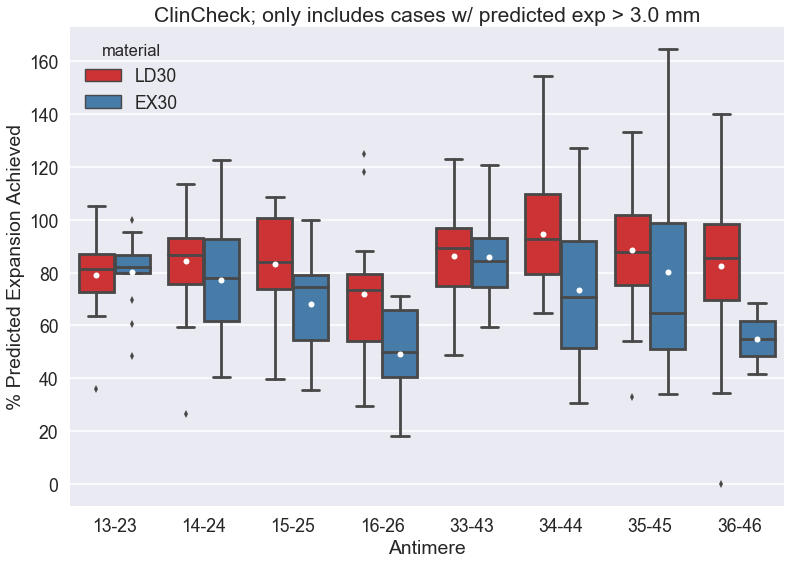

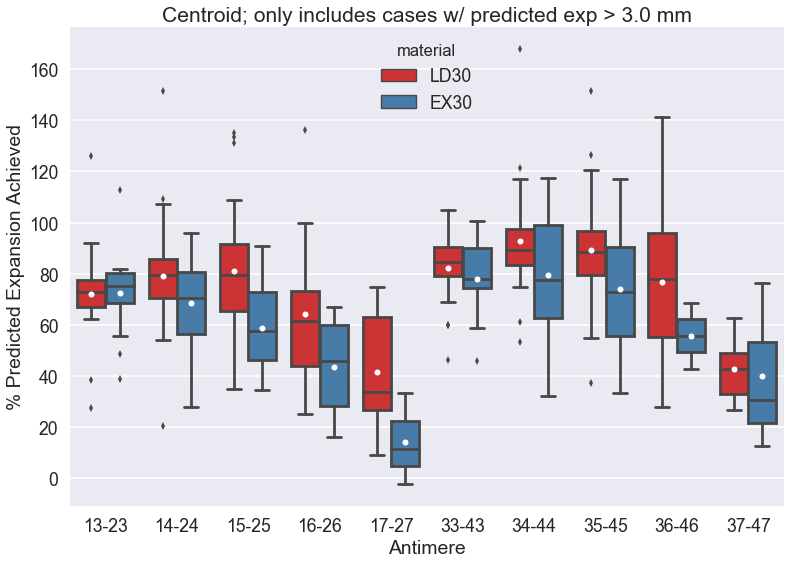

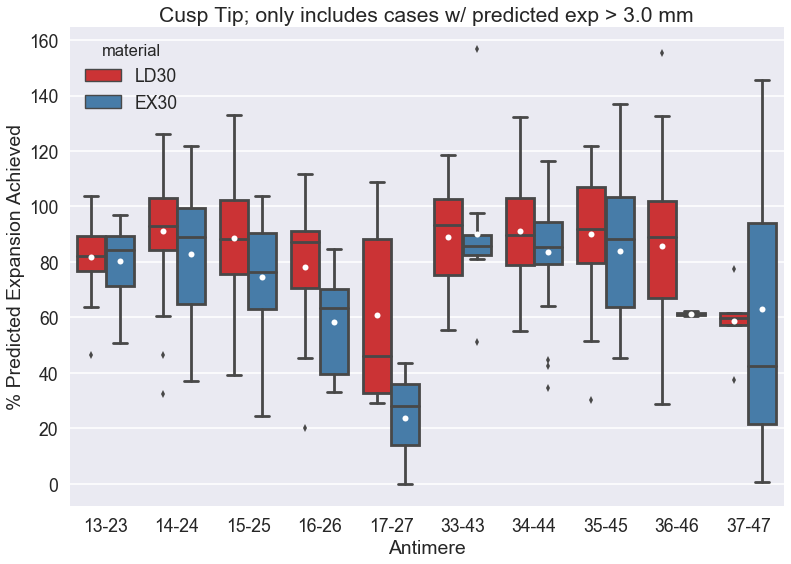

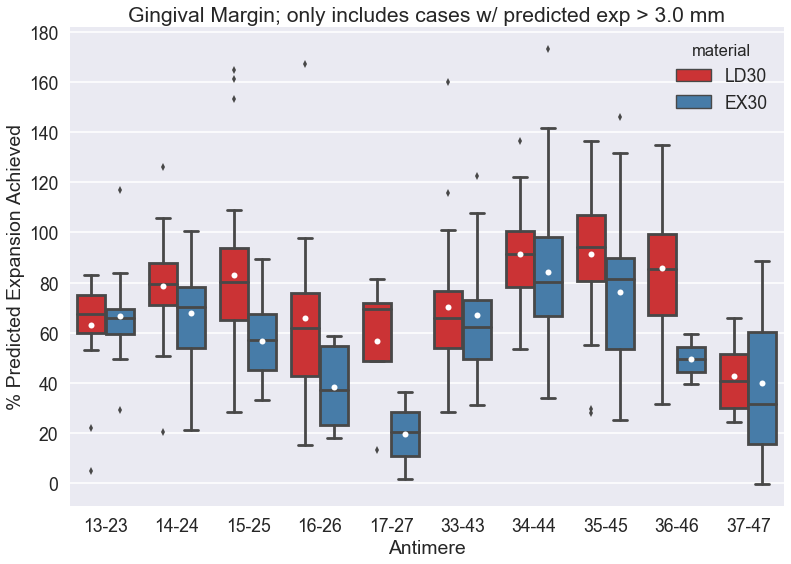

In [7]:
def LD30_vs_EX30_grouped_boxplot(df, measure_type, threshold, constant_n_obs=True):
    '''Grouped Boxplot: %Accuracy vs Antimere grouped by material (LD30 vs EX30), for a given measure_type;
    Only includes data where predicted exp > threshold.
    Also outputs .PDF of data.'''
    
    pp = PdfPages(os.path.join(OUTPUT_DIR, 'boxplots/LD30-vs-EX30-grouped-boxplots-%s.pdf' % (measure_type)))

    sns.set('poster', font_scale=1.1)

    f = plt.figure()    
    
    newDf = pd.DataFrame(columns = ['%acc', 'antimere', 'material'])
    
    for material in ['LD30', 'EX30']:
        for i, j in zip([1, 3], [2, 4]):
            for toothNum in range(3, 8):
                
                if measure_type == '.cc' and toothNum == 7:
                    continue
                
                antimere = '%s%s-%s%s' % (i, toothNum, j, toothNum)
                full_antimere = '%s%s-%s%s%s %%acc' % (i, toothNum, j, toothNum, measure_type)

                amDf = get_antimere_df(df, full_antimere, threshold, material, constant_n_obs)
                newDf = pd.concat([newDf, amDf], ignore_index=True)
    
    ax = sns.boxplot(x='antimere', y='%acc', hue='material', data=newDf, showmeans=True, palette="Set1", 
                     meanprops={"marker":"o","markerfacecolor":"white", "markeredgecolor":"black"})

    ## formatting
    ax.yaxis.set_major_locator(MultipleLocator(20))
    ax.yaxis.set_minor_locator(MultipleLocator(10))
    # ax.set_ylim((-20, 200))
    
    # Set titles
    ax.axes.set_title("%s; only includes cases w/ predicted exp > %s mm" % (measure_type_dict[measure_type], threshold))
    ax.set_xlabel("Antimere")
    ax.set_ylabel("% Predicted Expansion Achieved")
    sns.plt.show()
    
    pp.savefig(f, bbox_inches="tight")
    pp.close()
    
    return
for measure_type in MEASURE_TYPES:
    LD30_vs_EX30_grouped_boxplot(df, measure_type, THRESHOLD)

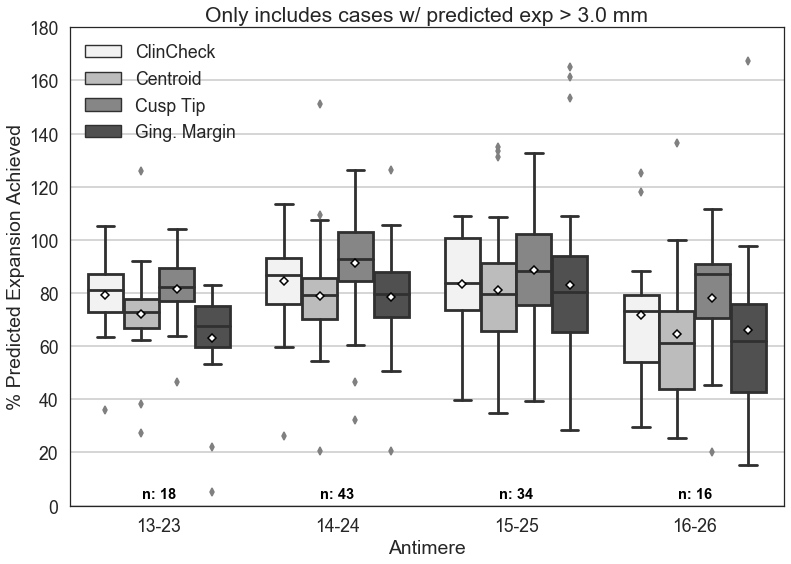

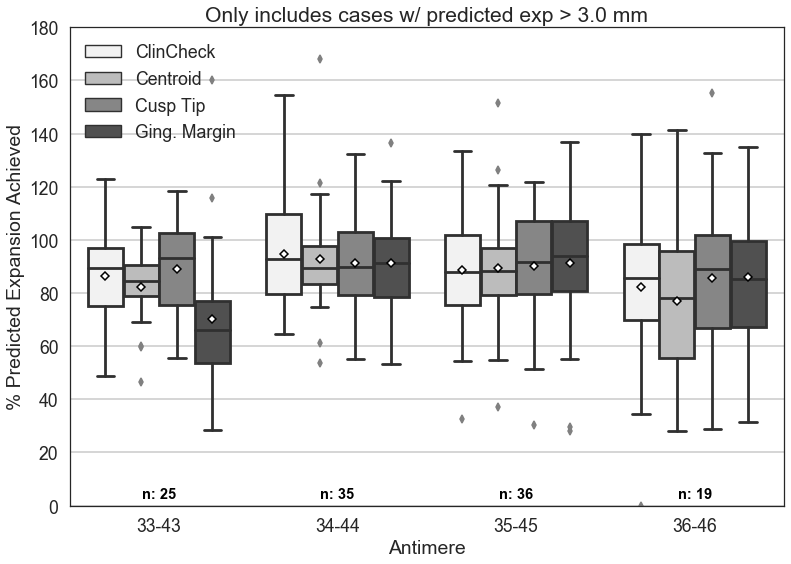

*Antimere: 13-23; ANOVA p: 0.00894101480294
*Antimere: 14-24; ANOVA p: 0.00351556743178
Antimere: 15-25; ANOVA p: 0.597398264355
Antimere: 16-26; ANOVA p: 0.50412739238
Antimere: 17-27; ANOVA p: nan
*Antimere: 33-43; ANOVA p: 0.00607671071441
Antimere: 34-44; ANOVA p: 0.842650743123
Antimere: 35-45; ANOVA p: 0.964489407854
Antimere: 36-46; ANOVA p: 0.798297858577
Antimere: 37-47; ANOVA p: nan


/Users/Richard/anaconda/envs/py36/lib/python3.6/site-packages/scipy/stats/stats.py:2952: RuntimeWarning: Mean of empty slice.
  offset = alldata.mean()
/Users/Richard/anaconda/envs/py36/lib/python3.6/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/Richard/anaconda/envs/py36/lib/python3.6/site-packages/scipy/stats/stats.py:2955: RuntimeWarning: invalid value encountered in double_scalars
  sstot = _sum_of_squares(alldata) - (_square_of_sums(alldata) / float(bign))
/Users/Richard/anaconda/envs/py36/lib/python3.6/site-packages/scipy/stats/stats.py:2958: RuntimeWarning: invalid value encountered in double_scalars
  ssbn += _square_of_sums(a - offset) / float(len(a))
/Users/Richard/anaconda/envs/py36/lib/python3.6/site-packages/scipy/stats/stats.py:2962: RuntimeWarning: invalid value encountered in double_scalars
  ssbn -= (_square_of_sums(alldata) / float(bign))
